<a href="https://colab.research.google.com/github/vhlucca/iBZR06AUoHyqC3EC/blob/main/Apziva_Term_Deposit_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import packages

In [1]:
!pip install shap optuna dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 4.4 MB/s eta 0:00:00


In [46]:
import time
import numpy as np
import pandas as pd
import shap
import lightgbm as lgm
#import pandas_profiling
#import sweetviz
#import dtale
import warnings, gc
#from pycaret.classification import *
import dtreeviz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.graph_objects as go
temp=dict(layout=go.Layout(font=dict(family="Arial", size=12), 
                           height=500, width=1000))

from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import TPESampler
import optuna
warnings.filterwarnings("ignore")

# Import and explore dataset

In [3]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


We check for duplicate rows and see that eery row is unique

In [5]:
#check for duplicate rows
len(df)-len(df.drop_duplicates())

0

We have to convert the target variable to binary

In [6]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,0
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,1
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,1
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,0


We can see that the target value is unbalaced, so we should use a stratified cross-validation method

In [7]:
target=df.y.value_counts(normalize=True)
pal, color=['#01707a','#d64075'], ['#01b8c9','#d96f94']
fig=go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45, 
                     showlegend=True,sort=False, 
                     marker=dict(colors=color,line=dict(color=pal,width=2.5)),
                     hovertemplate = "%{label} Accounts: %{value:.2f}%<extra></extra>"))
fig.update_layout(template=temp, 
                  legend=dict(traceorder='reversed',y=1.05,x=0),
                  uniformtext_minsize=15, uniformtext_mode='hide',width=700)
fig.show()

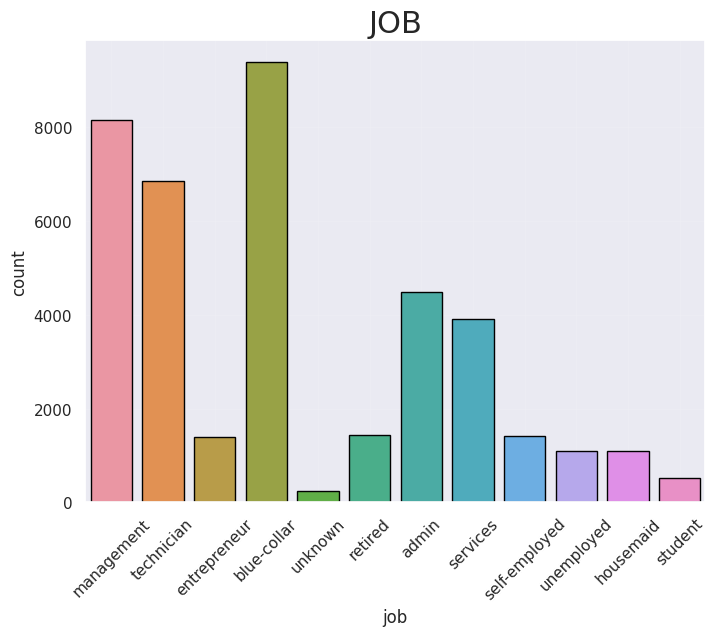

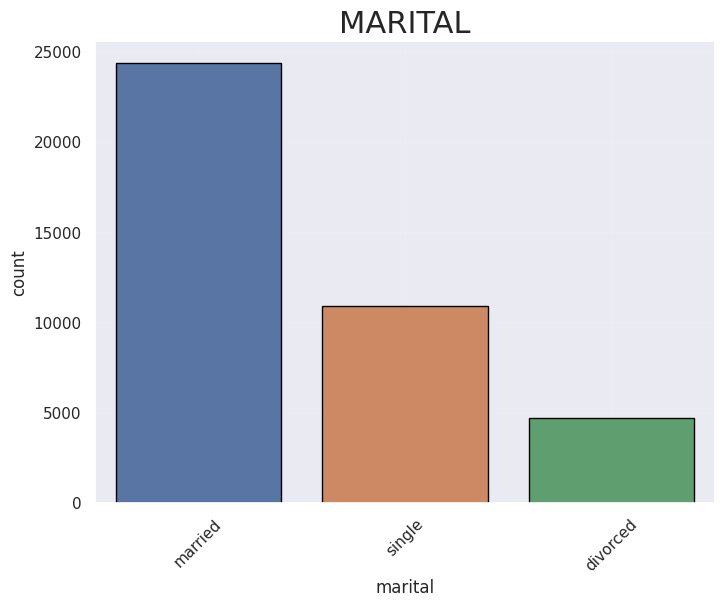

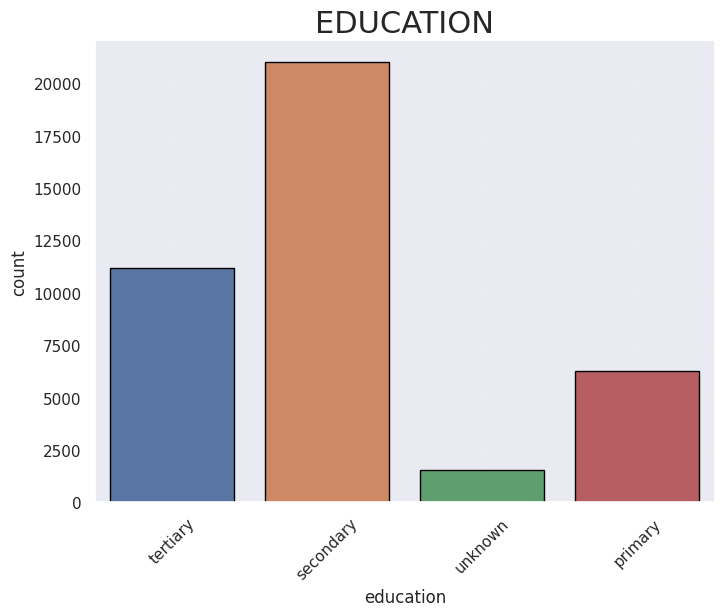

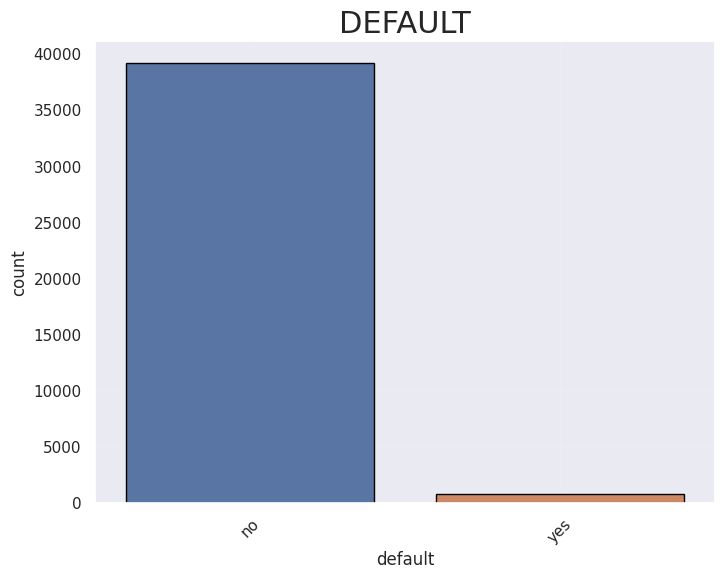

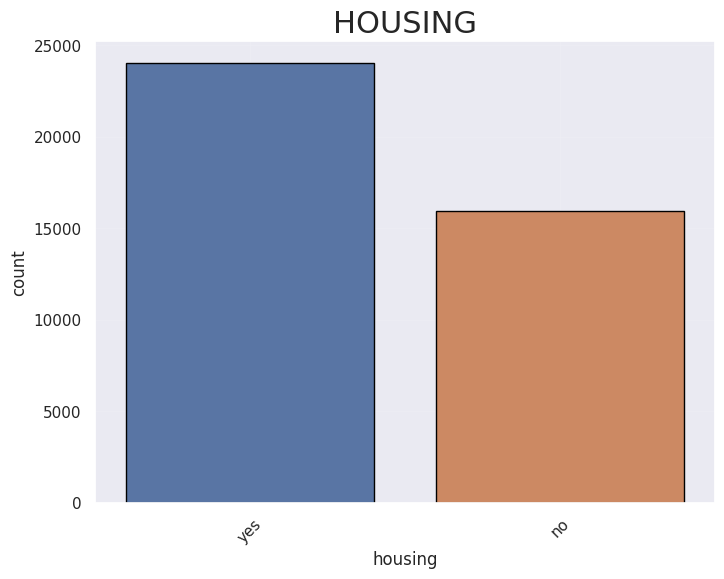

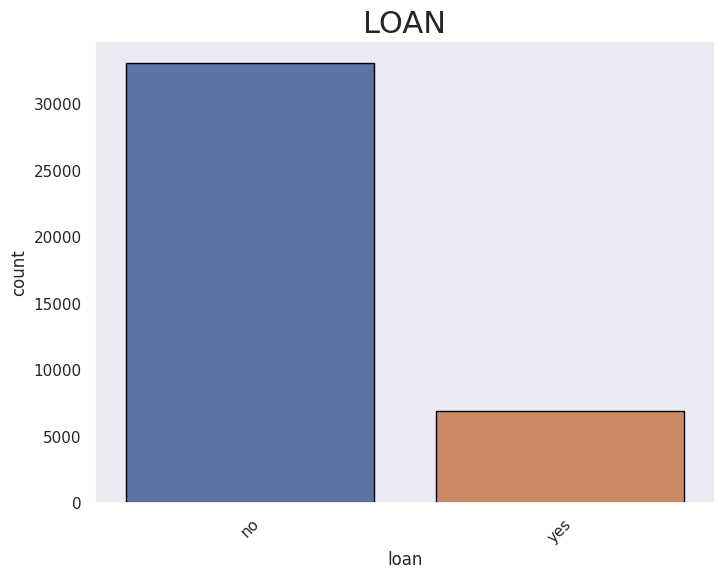

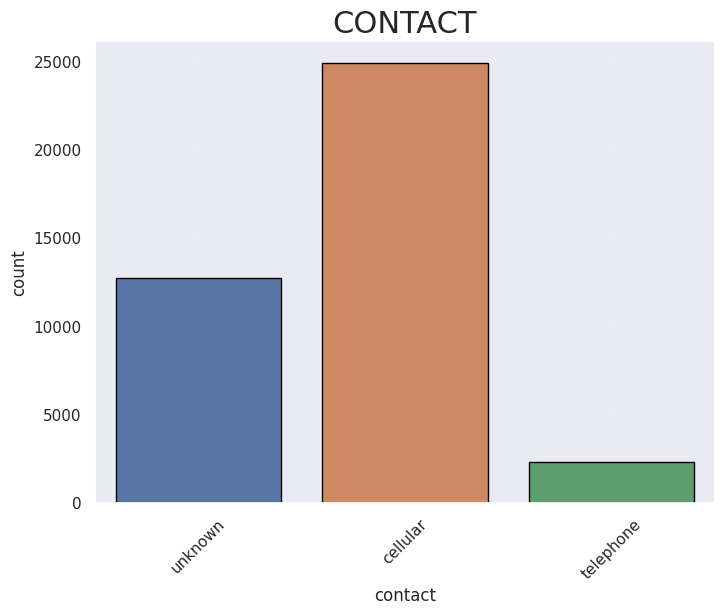

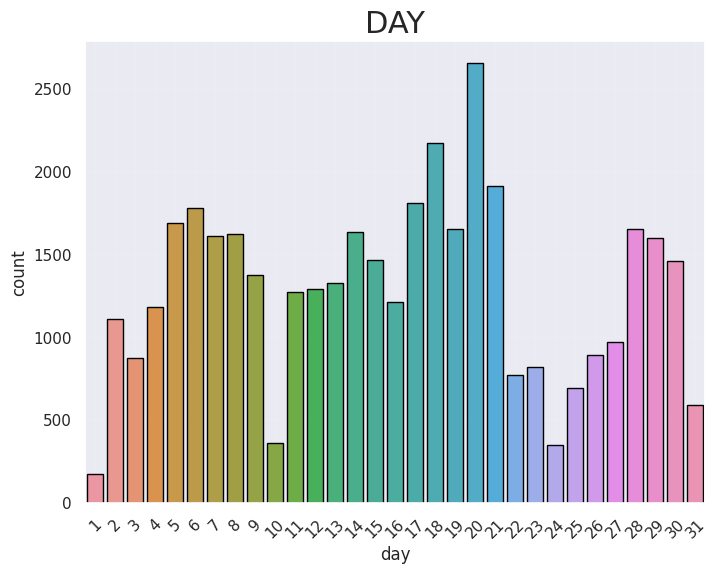

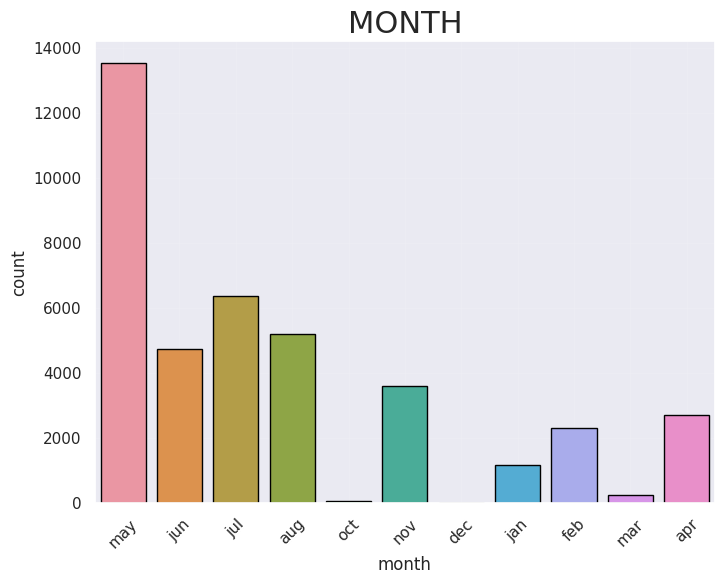

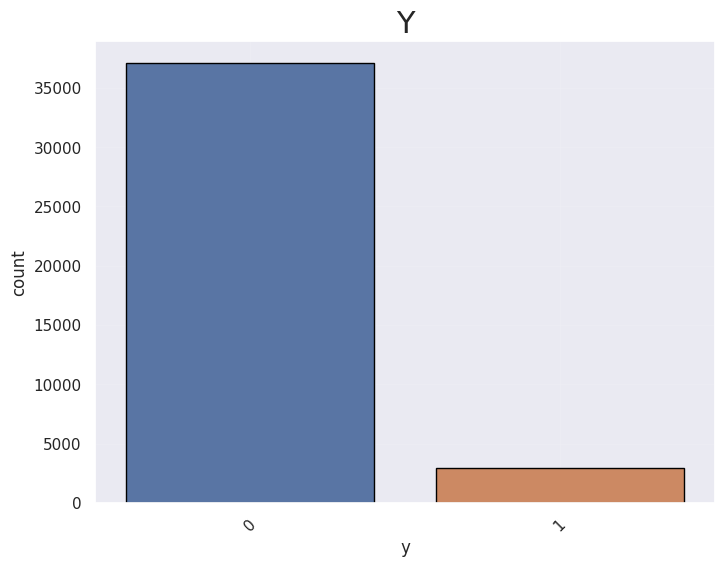

In [8]:
numerical_col = df[['age', 'balance', 'duration', 'campaign']]
for col in df.columns:
    if col not in numerical_col:
        sns.set(rc={'figure.figsize':(8,6)})
        sns.countplot(x=col, data=df,  edgecolor='black', linewidth=1) 
        plt.title(col.upper(), fontsize = 22)
        plt.grid(alpha=0.1)
        plt.xticks(rotation=45)
        plt.show()

Also, the numerical features are skewed to the left. In some cases it might be useful to transform these features to make them more like a normal distribution.

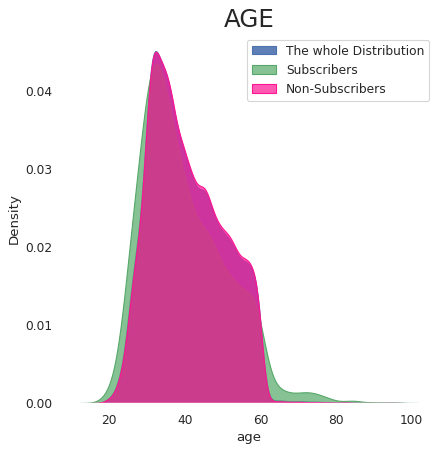

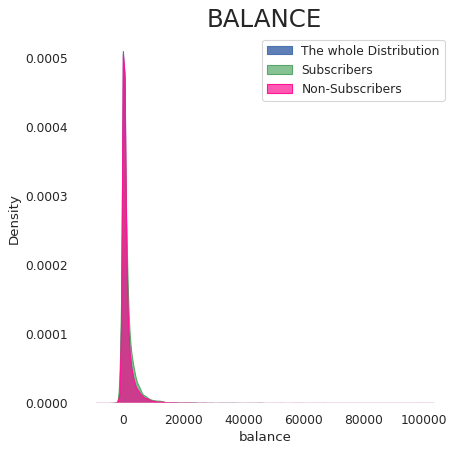

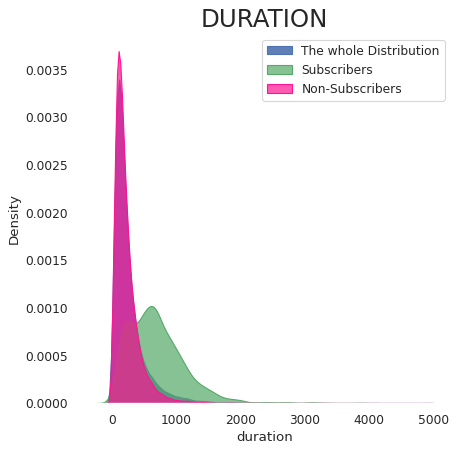

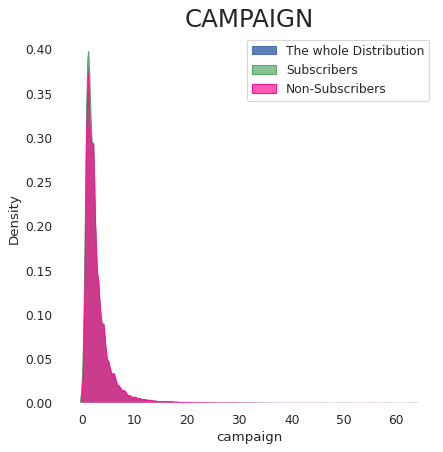

In [9]:
for col in numerical_col.columns:
    plt.figure(figsize=(6,6), dpi= 80)
    plt.rcParams['axes.facecolor'] = 'none'
    sns.kdeplot(numerical_col[col], shade=True, color="b",alpha=.9, label="The whole Distribution" )
    sns.kdeplot(df[df.y == 1][col], shade=True, color="g", label="Subscribers", alpha=.7)
    sns.kdeplot(df[df.y == 0][col], shade=True, color="deeppink", label="Non-Subscribers", alpha=.7)
    plt.title(col.upper(), fontsize=22)
    plt.legend()
    plt.show()

We have to create dummy variables for the categorical features.

In [10]:
df = pd.get_dummies(df)

In [11]:
df

,age,balance,day,duration,campaign,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,2143,5,261,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,44,29,5,151,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,2,5,76,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,47,1506,5,92,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,33,1,5,198,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,395,3,107,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
39996,30,3340,3,238,3,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
39997,54,200,3,170,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
39998,34,1047,3,342,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


We can also see that the feature with the highed correlation with the target is duration.

In [12]:
corr=df.corr()
corr=corr['y'].sort_values(ascending=True)[1:-1]
pal=sns.color_palette("Reds_r",135).as_hex()
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig = go.Figure()
fig.add_trace(go.Bar(x=corr[corr<=0], y=corr[corr<=0].index, 
                     marker_color=rgb, orientation='h', 
                     marker_line=dict(color=pal,width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))
pal=sns.color_palette("Blues",100).as_hex()
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig.add_trace(go.Bar(x=corr[corr>0], y=corr[corr>0].index, 
                     marker_color=rgb[25:], orientation='h', 
                     marker_line=dict(color=pal[25:],width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))
fig.update_layout(template=temp,title="Feature Correlations with Target",
                  xaxis_title="Correlação", margin=dict(l=150),
                  height=3000, width=700, hovermode='closest')
fig.show()

In [13]:
y = df['y']
X = df.drop(['y'], axis=1)

# Training and evaluating LightGBM model

In [14]:
def train_model(model, fold_no, rs):
    
    skf = StratifiedKFold(n_splits=fold_no, shuffle=True, random_state=rs)#26
    lst_accu_stratified = []
    lst_recall_stratified = []
    lst_f1_stratified = []
    #lst_report_stratified = []
    
    for train_index, test_index in skf.split(X, y):
        x_train_fold, x_test_fold = X.loc[train_index], X.loc[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        model.fit(x_train_fold, y_train_fold)
        y_pred = model.predict(x_test_fold)
        lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))
        lst_recall_stratified.append(recall_score(y_test_fold, y_pred))
        lst_f1_stratified.append(f1_score(y_test_fold, y_pred))
        #lst_report_stratified.append(classification_report(y_test_fold, y_pred))
    
    print('Model:', model)
    print('\nOverall Accuracy:',
          mean(lst_accu_stratified)*100, '%')
    
    print('\nOverall Recall:',
          mean(lst_recall_stratified)*100, '%')
    
    print('\nOverall F1:',
          mean(lst_f1_stratified)*100, '% \n')
    
    print('\nClassification Report:')
    print(classification_report(y_test_fold, y_pred))
    
    color = 'white'
    
    cm = confusion_matrix(y_test_fold, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()
    plt.show()

Model: LGBMClassifier(boosting_type='dart', metric='accuracy')

Overall Accuracy: 93.9025 %

Overall Recall: 42.747483771067834 %

Overall F1: 50.34260931233464 % 


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      7420
           1       0.58      0.46      0.51       580

    accuracy                           0.94      8000
   macro avg       0.77      0.72      0.74      8000
weighted avg       0.93      0.94      0.93      8000



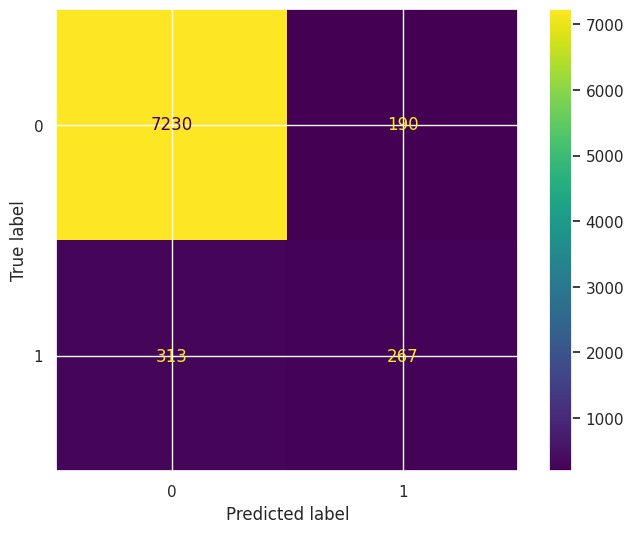

In [15]:
lgbm = LGBMClassifier(boosting_type= "dart", metric= "accuracy")
train_model(lgbm, 5, 35)

In [16]:
lgbm.get_params()

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'accuracy'}

In [17]:
def objective_lgbm(trial):
    """
    Objective function to be minimized.
    """
    
    param = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "metric": "accuracy",
        "verbosity": -1,
        "boosting_type": "dart",
        "n_estimators": trial.suggest_categorical("n_estimators", range(50,150,20)),
        "learning_rate": trial.suggest_float("learning_rate", 0.01,0.1, step=0.01),
        "num_leaves": trial.suggest_categorical("num_leaves", range(31,200,20))
        #"max_depth": trial.suggest_int("max_depth", 3, 12)
        
        
    }
    lgbm = LGBMClassifier(**param)
    scores = cross_val_score(lgbm, X, y, 
                             cv=StratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=35),
                             scoring="recall"
                            )
    
    return scores.mean()



In [18]:
# Create Study object
study = optuna.create_study(direction="maximize")
# Optimize the study, use more trials to obtain better result, use less trials to be more cost-efficient
study.optimize(objective_lgbm, n_trials=30) # Use more 
# Print the result
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

[I 2023-04-17 21:47:44,783] A new study created in memory with name: no-name-82458d3f-519d-4c76-9dea-96f27d79fe77
[I 2023-04-17 21:47:51,747] Trial 0 finished with value: 0.45060925495801313 and parameters: {'n_estimators': 70, 'learning_rate': 0.09, 'num_leaves': 171}. Best is trial 0 with value: 0.45060925495801313.
[I 2023-04-17 21:47:54,766] Trial 1 finished with value: 0.3342403668632005 and parameters: {'n_estimators': 50, 'learning_rate': 0.060000000000000005, 'num_leaves': 91}. Best is trial 0 with value: 0.45060925495801313.
[I 2023-04-17 21:48:04,811] Trial 2 finished with value: 0.386729200166756 and parameters: {'n_estimators': 90, 'learning_rate': 0.09999999999999999, 'num_leaves': 171}. Best is trial 0 with value: 0.45060925495801313.
[I 2023-04-17 21:48:10,747] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 90, 'learning_rate': 0.01, 'num_leaves': 51}. Best is trial 0 with value: 0.45060925495801313.
[I 2023-04-17 21:48:24,940] Trial 4 finished with va

Best score: 0.4592418557560598

Optimized parameters: {'n_estimators': 70, 'learning_rate': 0.06999999999999999, 'num_leaves': 111}



Model: LGBMClassifier(boosting_type='dart', learning_rate=0.06999999999999999,
               metric='accuracy', n_estimators=70, num_leaves=111)

Overall Accuracy: 93.72749999999999 %

Overall Recall: 45.92418557560598 %

Overall F1: 51.44414291227398 % 


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      7420
           1       0.56      0.49      0.53       580

    accuracy                           0.94      8000
   macro avg       0.76      0.73      0.75      8000
weighted avg       0.93      0.94      0.93      8000



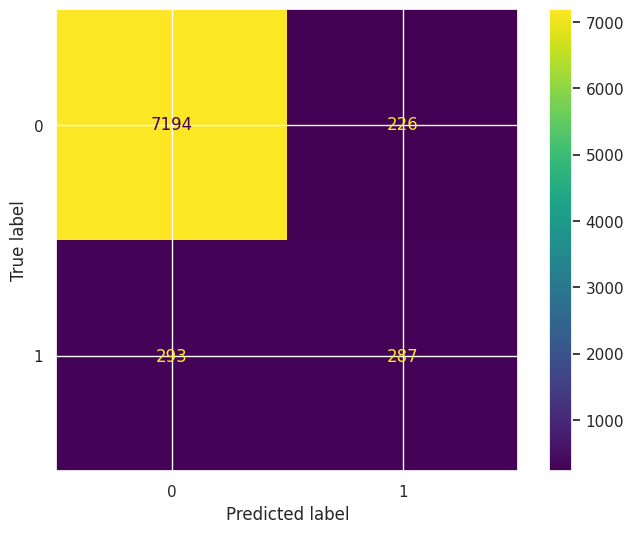

In [19]:
best_params_lgbm=study.best_params
lgbm_tune = LGBMClassifier(**best_params_lgbm, boosting_type= "dart", metric= "accuracy")
train_model(lgbm_tune, 5, 35)

In [26]:
lgbm_tune.get_params()

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.06999999999999999,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 70,
 'n_jobs': -1,
 'num_leaves': 91,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'accuracy'}

After training and tuning the model we reached a accuracy of 93,73%, which is cosiderably better than the 81% base line.

Furthermore, we looked at the recall because accuracy all alone might not be the best metric since the data is unbalanced.

In [20]:
df_trees = lgbm_tune.booster_.trees_to_dataframe()

Below we have a table that explains each one of the trees in the ensemble model. A higher value means more weak learners contribute towards the final output but increasing it significantly slows down the training time.

In [21]:
df_trees

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S1,0-S3,None,duration,6464.459961,6.075000e+02,<=,left,None,-1.639780,0.000000,32000
1,0,2,0-S1,0-S2,0-S9,0-S0,duration,715.052002,4.105000e+02,<=,left,None,-1.662710,1977.650000,29457
2,0,3,0-S2,0-S4,0-S8,0-S1,month_mar,576.421021,1.000000e-35,<=,left,None,-1.671250,1798.600000,26790
3,0,4,0-S4,0-S5,0-S14,0-S2,month_oct,287.234985,1.000000e-35,<=,left,None,-1.673440,1785.370000,26593
4,0,5,0-S5,0-S13,0-S6,0-S4,month_apr,271.695007,1.000000e-35,<=,left,None,-1.674290,1781.410000,26534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15465,69,9,69-S72,69-L72,69-L73,69-S71,day,3.704570,1.950000e+01,<=,left,None,0.006189,14.846300,64
15466,69,10,69-L72,None,None,69-S72,None,NaN,NaN,None,None,None,-0.000726,6.165424,26
15467,69,10,69-L73,None,None,69-S72,None,NaN,NaN,None,None,None,0.011100,8.680839,38
15468,69,7,69-L68,None,None,69-S67,None,NaN,NaN,None,None,None,-0.006550,5.461826,23


In [22]:
df_trees_gb = df_trees.groupby(['tree_index']).sum().sort_values('split_gain', ascending=False)
df_trees_gb

,node_depth,split_gain,threshold,value,weight,count
tree_index,,,,,,
0,1755,13345.144495,21807.0,-320.200342,18719.774094,310830
1,1843,8263.735234,25207.0,21.455292,18185.278834,300848
2,1839,6165.546514,37063.0,21.511768,16780.726893,283106
3,1877,4980.744558,25984.0,19.496084,15957.952636,266571
4,2021,4125.161053,27992.5,8.056973,15174.705991,263407
...,...,...,...,...,...,...
61,2383,452.296090,47042.5,-4.595341,17741.230128,296202
62,2229,445.650311,55818.0,-3.095150,17018.380716,296136
66,2107,444.616229,23683.5,-3.521593,15038.339875,248928


Our model in composed of 70 trees, and the one in the index=0 is the one with higher influence responding to 12,5% of it.

In [23]:
100*df_trees_gb['split_gain']/df_trees_gb['split_gain'].sum()

tree_index
0     12.541073
1      7.765829
2      5.794060
3      4.680645
4      3.876612
        ...    
61     0.425044
62     0.418799
66     0.417827
65     0.414444
67     0.387941
Name: split_gain, Length: 70, dtype: float64

So we are analysing the index=0.

Below we have the tree plot and that the most relevant split happens in duration≤607.50, the second one at duration≤410.50 and the third one at month_mar≤0.000.

So the company should prioritize clients with duration higher than 607.50.

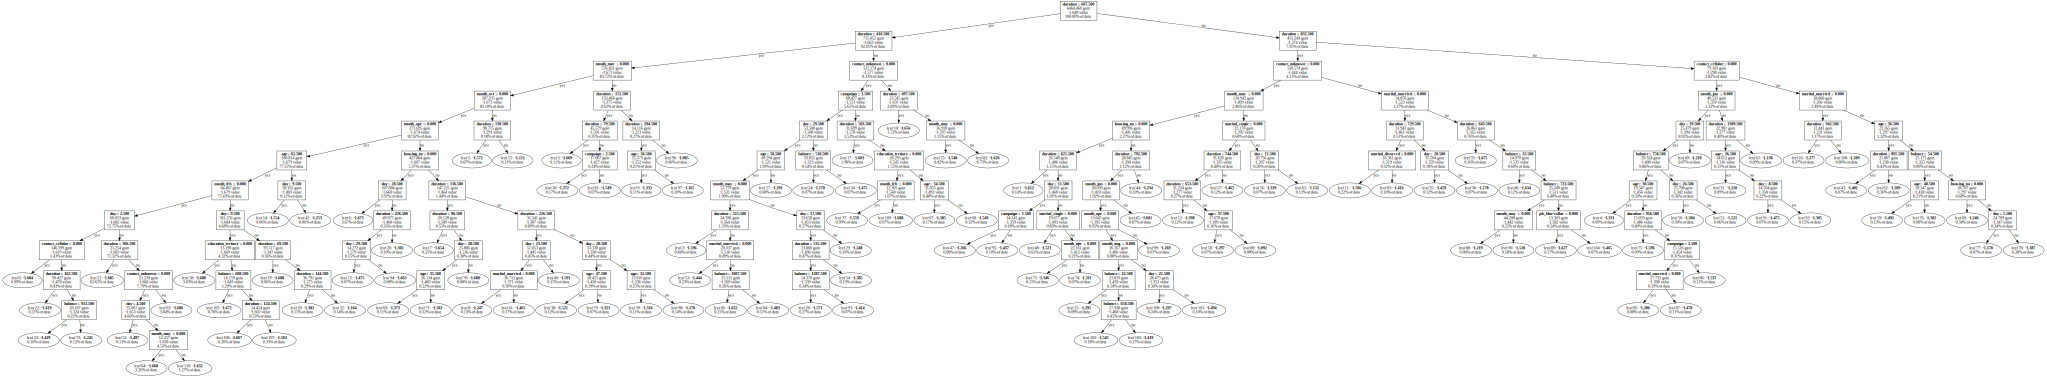

In [47]:
lgm.create_tree_digraph(lgbm_tune, tree_index=0, orientation='vertical', 
                        show_info=['split_gain', 'data_percentage', 'internal_value'])

# Feature Importance

What makes the customers buy? Tell us which feature we should be focusing more on.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

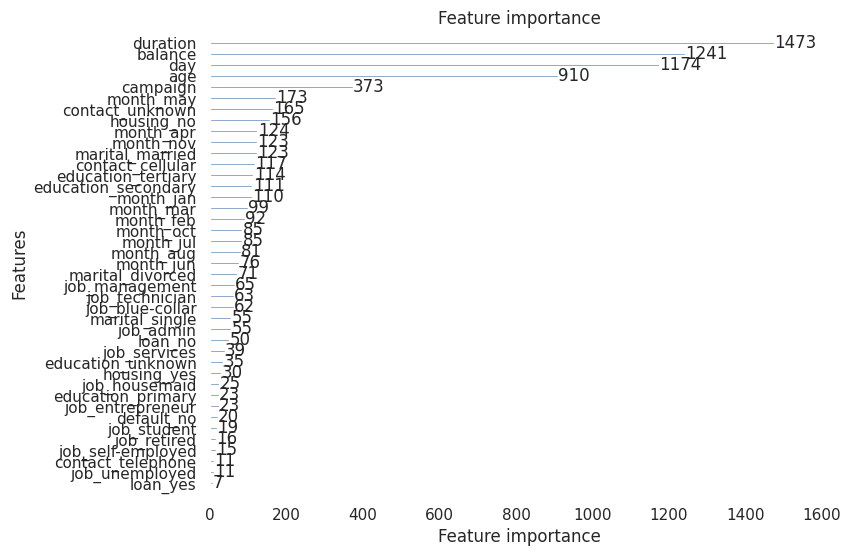

In [25]:
lgm.plot_importance(lgbm_tune)

100%|===================| 39983/40000 [03:49<00:00]       

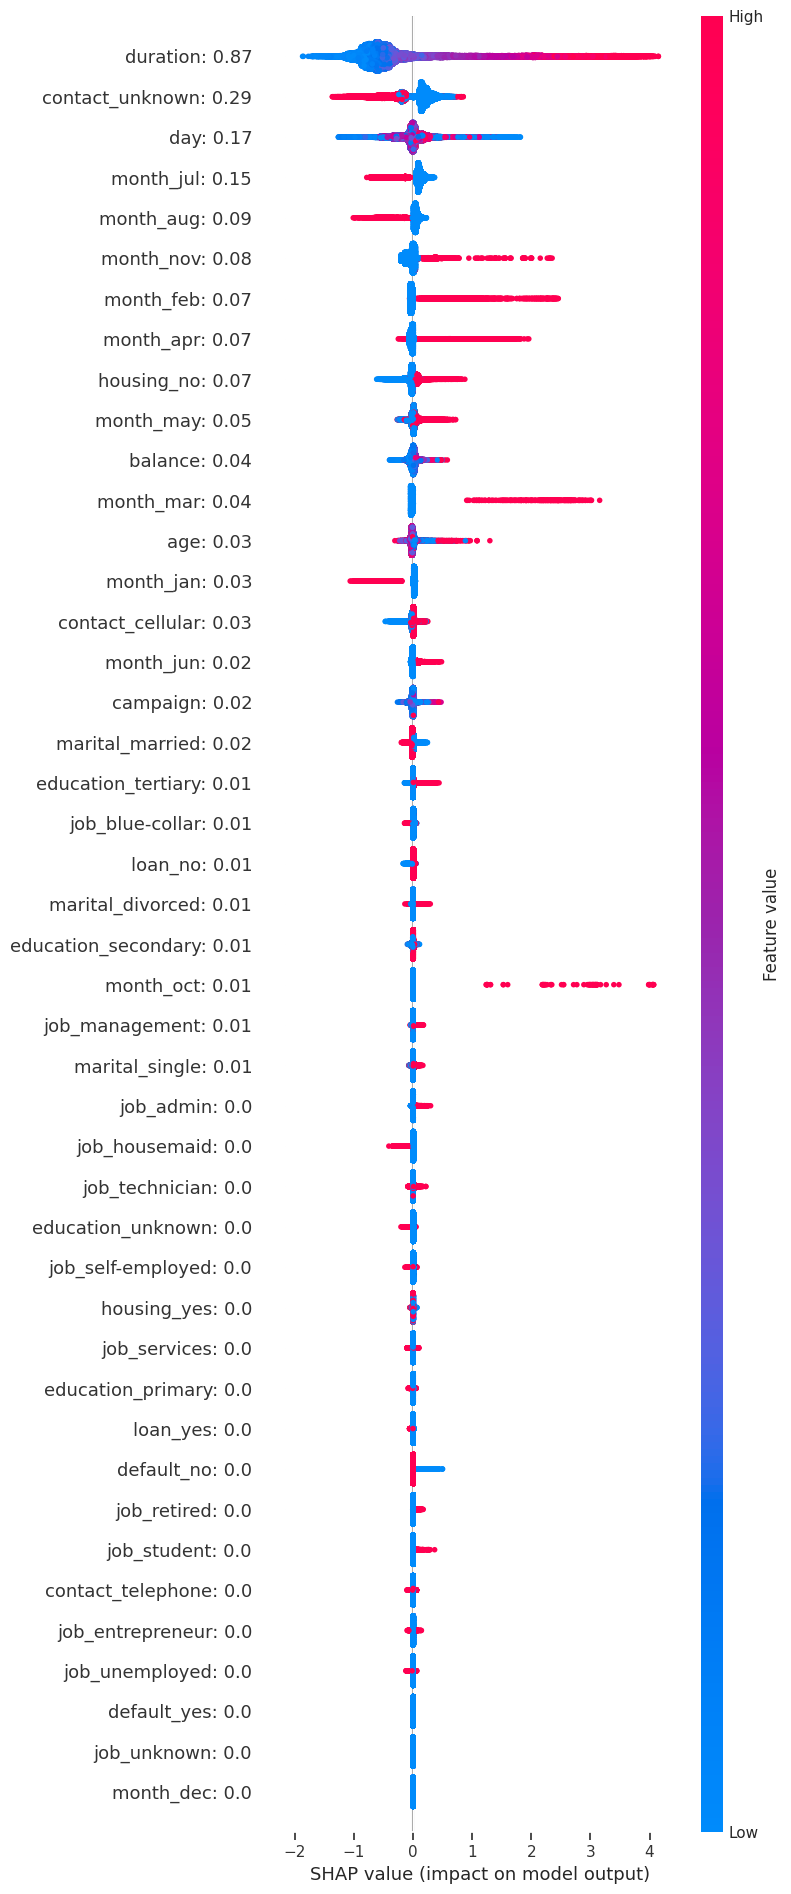

In [26]:
explainer = shap.TreeExplainer(lgbm_tune, data=X)
shap_values = explainer.shap_values(X)

feature_names = [
    a + ": " + str(b) for a,b in zip(X.columns, np.abs(shap_values).mean(0).round(2))
]

shap.summary_plot(shap_values, X, max_display=X.shape[1], 
                  feature_names=feature_names)

Here is how to interpret the above plot:

1. The left vertical axis denotes feature names, ordered based on importance from top to bottom.
2. The horizontal axis represents the magnitude of the SHAP values for predictions.
3. The vertical right axis represents the actual magnitude of a feature as it appears in the dataset and colors the points.

We see that as duration increases, its effect on the model is more positive. The opposite is happens for contanct unknown feature.

So the 3 most important features for the model are duration (the higher the better), contact_unknown (more contact the better) and day (most likely to subscribed to a term deposit in the middle of the month).

What makes the customer buy is high last contact duration, if the person has a contact, and the day of the month. Perhaps because the clients receive their payments close to the middle of the month.

In [ ]:
shap.dependence_plot("duration", shap_values, df, interaction_index="auto")

## References

https://www.freecodecamp.org/news/customer-segmentation-python-machine-learning/

https://christophm.github.io/interpretable-ml-book/shapley.html

https://mljar.com/blog/visualize-decision-tree/

https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

https://medium.com/data-hackers/como-avaliar-seu-modelo-de-classifica%C3%A7%C3%A3o-34e6f6011108

https://towardsdatascience.com/a-complete-shap-tutorial-how-to-explain-any-black-box-ml-model-in-python-7538d11fae94

https://towardsdatascience.com/lightgbm-algorithm-an-end-to-end-review-on-the-trees-to-dataframe-method-13e8c4b74027

https://neptune.ai/blog/xgboost-vs-lightgbm

https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.OptunaSearchCV.html#optuna.integration.OptunaSearchCV.score

https://towardsdatascience.com/tuning-hyperparameters-with-optuna-af342facc549